In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [2]:
from utils import helper_functions as hf
import change_detection as cd
import Config as Config

In [299]:
files_in_anomaly_directory = os.listdir(Config.ANOMALY_VIDEO_DIRECTORY)
anomaly_video_file = random.choice(files_in_anomaly_directory)
anomaly_video_file_path = os.path.join(Config.ANOMALY_VIDEO_DIRECTORY, anomaly_video_file)
anomaly_video_file_path

'./videos/Anomaly Videos/Abuse004_x264.mp4'

In [5]:
model = tf.keras.models.load_model(Config.FINE_TUNED_LSTM_AUTO_ENCODER_PATH)

2023-08-12 23:10:44.608106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [300]:
#Extracting all the frames
video_frames_dict = hf.get_frames_from_video(anomaly_video_file_path)

In [301]:
len(video_frames_dict)

16794

In [302]:
frames_in_batches = hf.get_frames_in_batches(30, video_frames_dict)

In [303]:
frame_sequence_tracker = hf.get_frame_sequence_tracker(frames_in_batches)

In [304]:
len(frame_sequence_tracker)

559

In [305]:
frame_sequence_tracker[1].shape

(30, 256, 256, 1)

In [306]:
significant_keys = cd.perform_change_detection(frame_sequence_tracker)

In [ ]:

significant_keys

In [308]:
#Testing the logic of comparison with insignificant frames
insignificant_keys = []


for k in range(1, significant_keys[0]):
    if k not in significant_keys:
        insignificant_keys.append(k)
        break
if len(insignificant_keys) == 0:
    print('Empty Insignificant Key')
    for k in range(1, significant_keys[-1]):
        if k not in significant_keys:
            insignificant_keys.append(k)
            break

Empty Insignificant Key


In [309]:
insignificant_keys

[2]

In [310]:
        
#Checking the prediction value of insignificant frame
insig_cost_tracker = {}

for key in insignificant_keys:
    insignificant_sequence = frame_sequence_tracker[insignificant_keys[0]]
    reshaped_insignificant_sequences = insignificant_sequence.reshape(3, 10, 256, 256, 1)

    for index, single_sequence in enumerate(reshaped_insignificant_sequences):
            single_sequence = np.expand_dims(single_sequence, axis=0)
            reconstructed_sequence = model.predict(single_sequence)  

            # Calculating reconstruction cost for the single sequence
            cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
            insig_cost_tracker[f'{key}_{index}'] = cost

1/1 [==============================] - 0s 37ms/step


In [311]:
insig_cost_tracker

{'2_0': 49.894558, '2_1': 49.925934, '2_2': 49.92326}

In [312]:
insig_cost_tracker

{'2_0': 49.894558, '2_1': 49.925934, '2_2': 49.92326}

In [313]:
def get_max_from_cost_dict(cost_dict):
    max = 0
    
    for key, value in cost_dict.items():
        if value > max:
            max = value
    return max

In [314]:
def get_anomaly_threshold_from_normal_cost(cost):
    five_percent_cost = 0.05 * cost
    anomaly_threshold = five_percent_cost + cost
    return anomaly_threshold    

In [315]:
max_insignificant_prediction_score = get_max_from_cost_dict(insig_cost_tracker)

In [316]:
max_insignificant_prediction_score

49.925934

In [317]:
max_insignificant_prediction_score

49.925934

In [318]:
anomaly_threshold = get_anomaly_threshold_from_normal_cost(max_insignificant_prediction_score)
anomaly_threshold

52.42223052978515

In [319]:
anomaly_threshold = get_anomaly_threshold_from_normal_cost(max_insignificant_prediction_score)
anomaly_threshold

52.42223052978515

In [320]:
cost_tracker = {}
for key in significant_keys:
    significant_sequence = frame_sequence_tracker[key]
    reshaped_sequences = significant_sequence.reshape(3, 10, 256, 256, 1)
    for index, single_sequence in enumerate(reshaped_sequences):
        single_sequence = np.expand_dims(single_sequence, axis=0)
        reconstructed_sequence = model.predict(single_sequence)  
        
        # Calculating reconstruction cost for the single sequence
        cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
        cost_tracker[f'{key}_{index}'] = cost


1/1 [==============================] - 0s 27ms/step


In [321]:
insignificant_keys

[2]

In [322]:
keys_to_consider = set() #Defining as a set to avoid duplicates

In [323]:
len(cost_tracker)

243

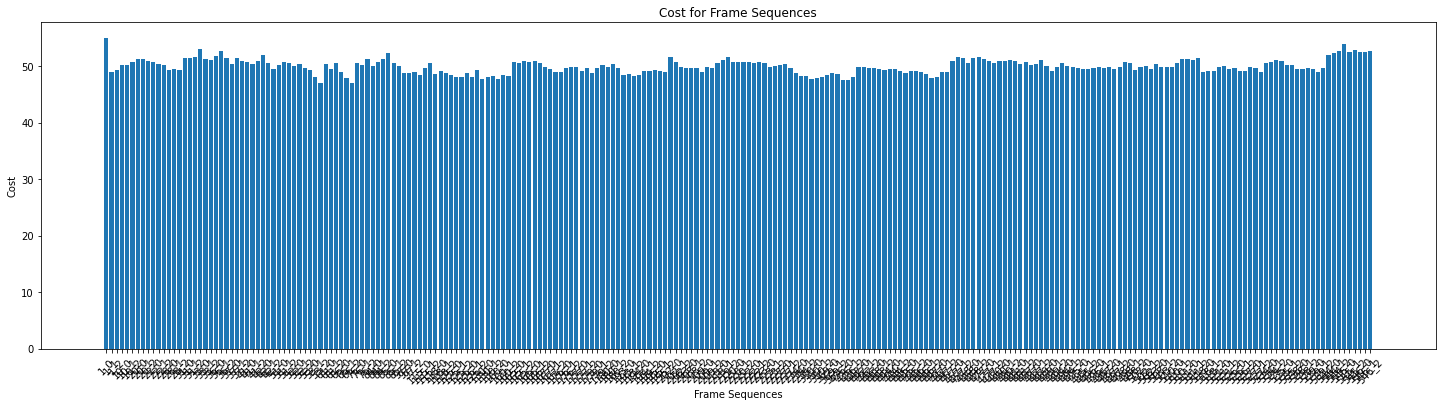

In [324]:
keys = list(cost_tracker.keys())
values = list(cost_tracker.values())

# Plotting
plt.figure(figsize=(25, 6))
plt.bar(keys, values)
plt.xlabel('Frame Sequences')
plt.ylabel('Cost')
plt.title('Cost for Frame Sequences')
plt.xticks(rotation=45)  # Rotating x-axis labels for visibility
# plt.tight_layout()
plt.show()

In [325]:
# Logic to extract frames with more reconstruction cost
for index, cost in cost_tracker.items():
    if cost > anomaly_threshold:
        keys_to_consider.add(index)
        
if len(keys_to_consider) == 0:
    for index,cost in cost_tracker.items():
        if cost > max_insignificant_prediction_score:
            keys_to_consider.add(index)

In [326]:
keys_to_consider

{'1_0',
 '33_0',
 '36_1',
 '544_2',
 '545_0',
 '545_1',
 '545_2',
 '546_0',
 '546_1',
 '546_2'}

In [327]:
#Logic to populate original frames for video summarization

original_frames_for_summarization = []

frame_key_list = []

for items in keys_to_consider:
    key = int(items.split('_')[0])
    frame_key_list.append(key)
   

In [328]:
frame_key_list

[545, 545, 546, 544, 36, 1, 546, 546, 33, 545]

In [329]:
sorted_key_list = sorted(frame_key_list)
initial_frame_key = sorted_key_list[0]
end_frame_key = sorted_key_list[-1]

#Appending buffer frame for initial sequence
if initial_frame_key > 3:
    sorted_key_list.append(initial_frame_key - 1)
    sorted_key_list.append(initial_frame_key - 2)
    
#Appending buffer frame for final sequence
if (end_frame_key + 1) in video_frames_dict:
    sorted_key_list.append(end_frame_key + 1)
    
frame_key_set = set(sorted(sorted_key_list))
frame_key_list = sorted(list(frame_key_set))
frame_key_list

[1, 33, 36, 544, 545, 546, 547]

In [330]:
final_frames_list = []
for i in range(len(frame_key_list)):
    if i == 0 or i == len(frame_key_list) - 1:
        final_frames_list.append(frame_key_list[i])
    elif frame_key_list[i] != frame_key_list[i - 1]:
        final_frames_list.append(frame_key_list[i] - 1)
        final_frames_list.append(frame_key_list[i])
    else:
        final_frames_list.append(frame_key_list[i])
final_frames_list = set(final_frames_list)
final_frames_list = sorted(list(final_frames_list))
final_frames_list
    

[1, 32, 33, 35, 36, 543, 544, 545, 546, 547]

In [294]:
new_st1, new_end1 = hf.get_original_frame_numbers(32,30)
new_st1,new_end1

(931, 960)

In [331]:
for key in final_frames_list:
    start, end = hf.get_original_frame_numbers(key,30)
    for j in range(start, end + 1):
        original_frame = video_frames_dict[j]
        original_frames_for_summarization.append(original_frame)

In [332]:
len(original_frames_for_summarization)

300

In [333]:
original_frames_for_summarization[-1].shape

(240, 320, 3)

In [334]:
fourcc = fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
frame_size = (original_frames_for_summarization[0].shape[1], original_frames_for_summarization[0].shape[0])
out = cv2.VideoWriter('anomaly_out_video1.mp4', fourcc, fps, frame_size)


for frame in original_frames_for_summarization:
    out.write(frame)
out.release()

In [179]:
out

<VideoWriter 0x7f9a14337f70>

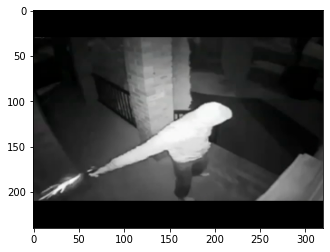

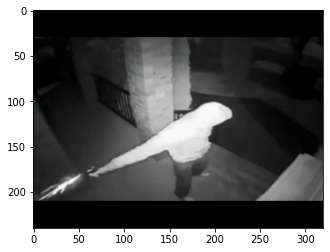

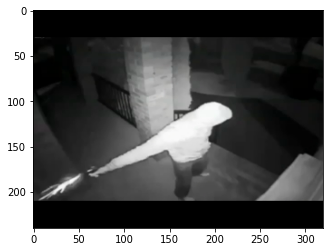

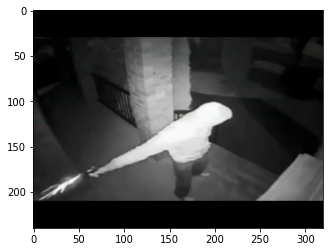

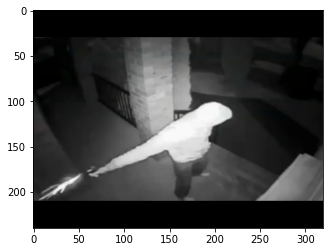

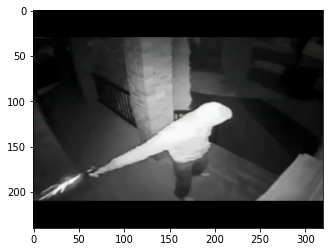

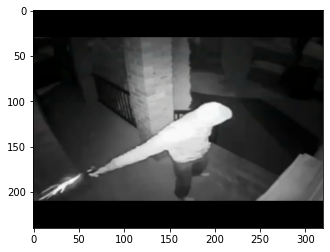

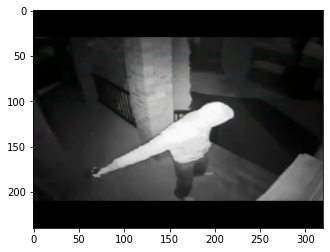

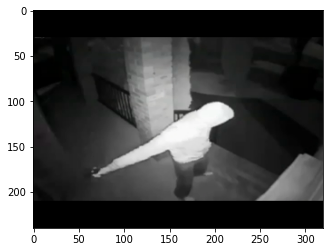

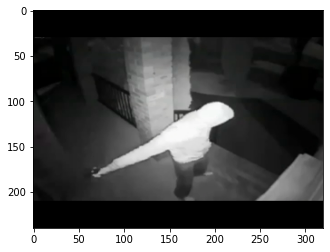

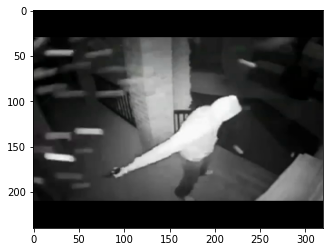

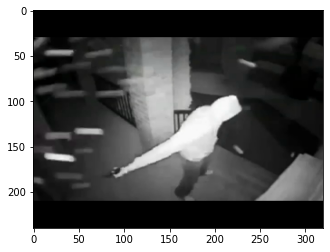

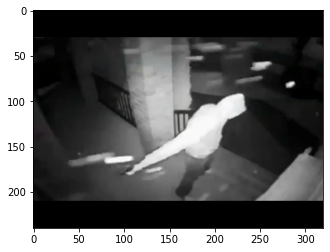

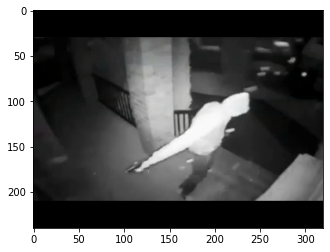

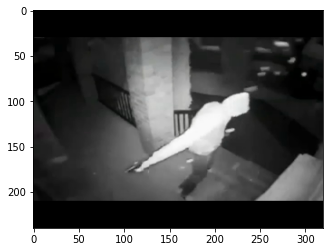

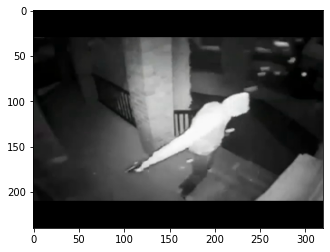

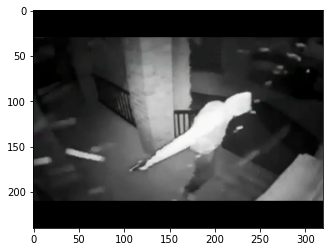

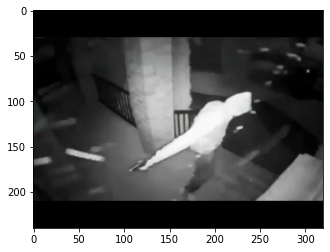

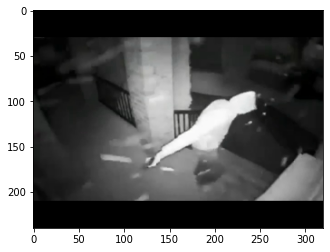

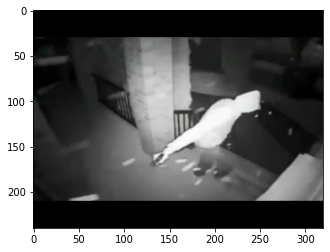

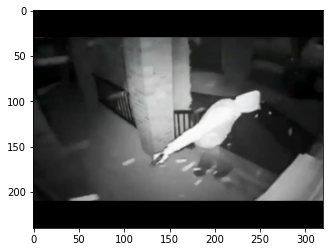

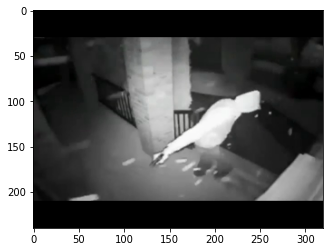

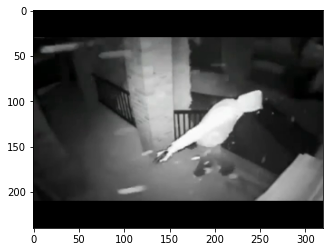

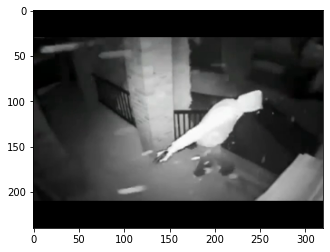

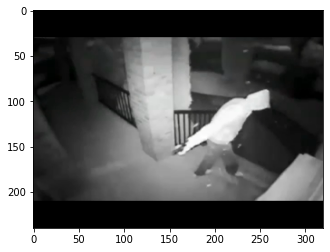

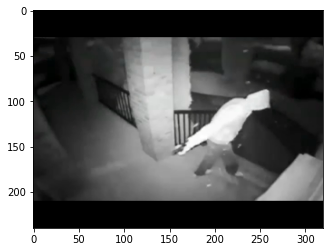

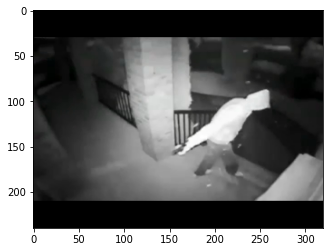

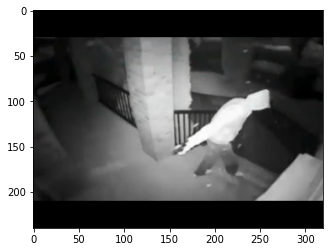

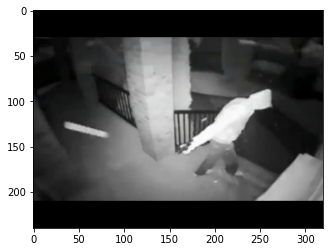

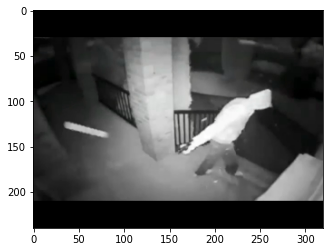

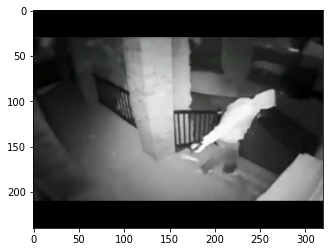

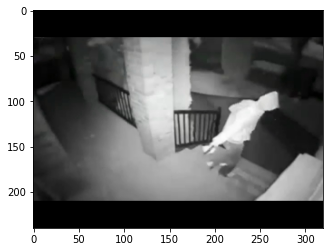

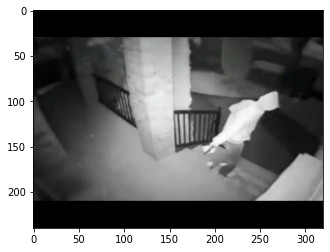

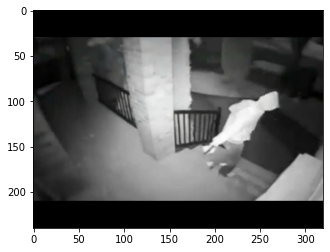

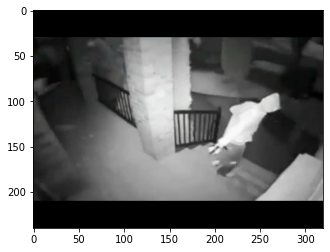

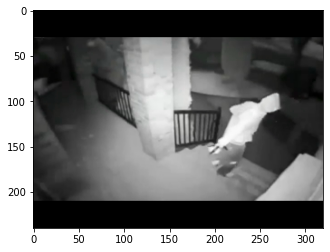

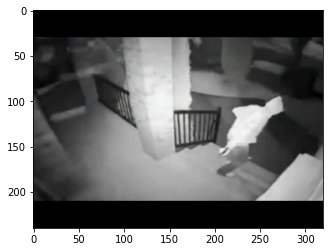

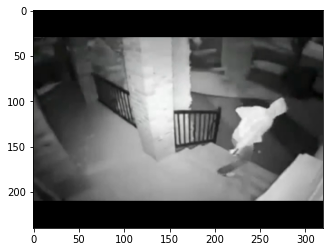

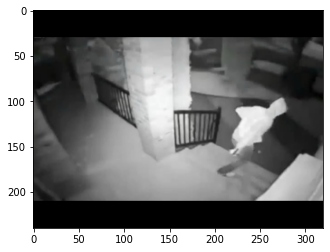

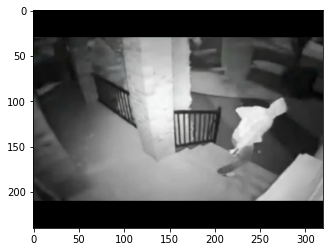

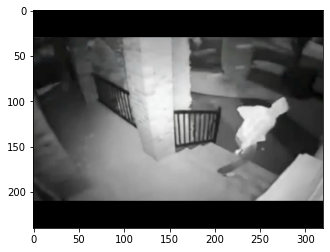

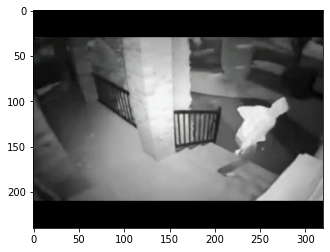

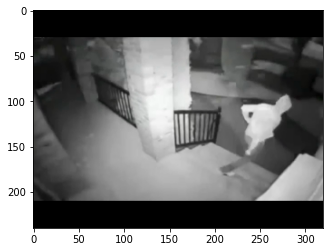

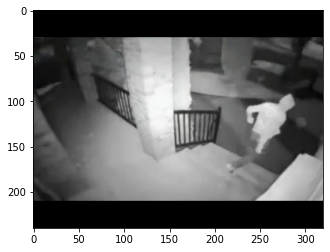

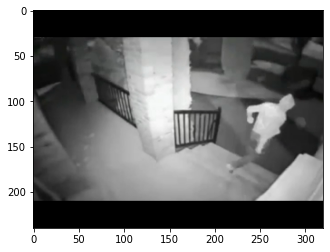

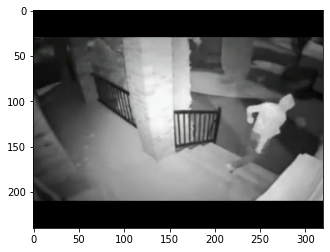

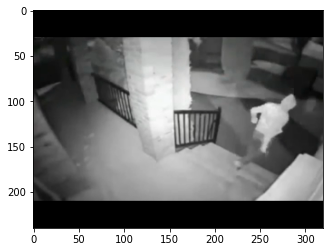

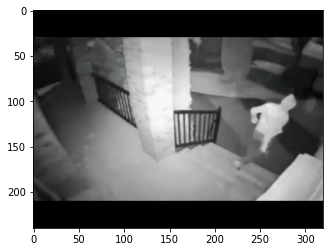

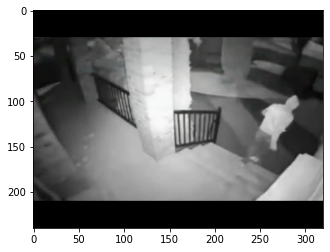

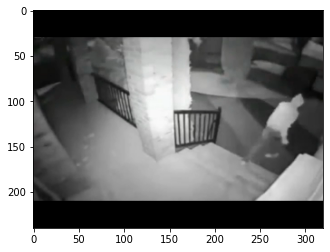

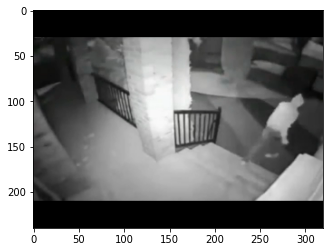

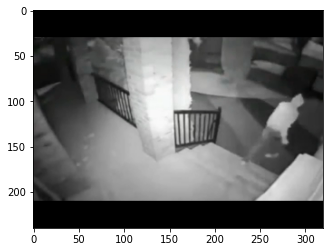

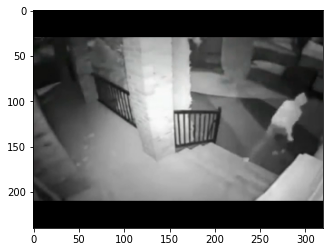

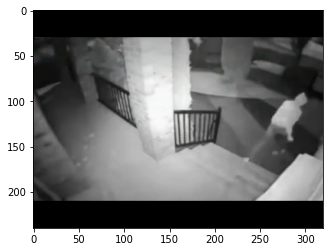

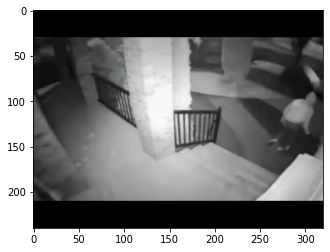

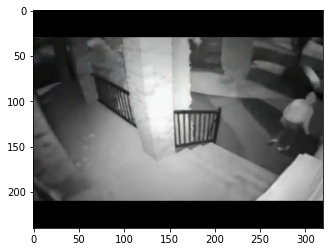

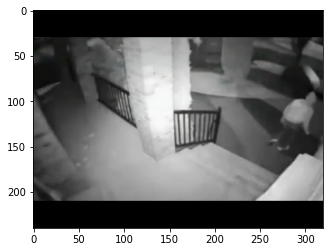

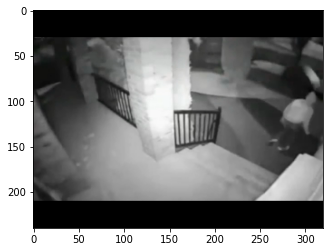

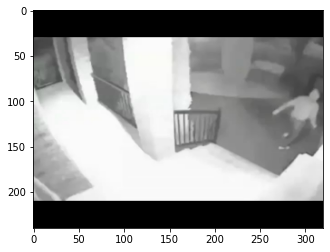

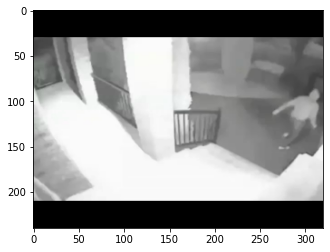

In [87]:

for i in range(new_st1 - 30, new_end1 + 1):
    original_frame = video_frames_dict[i]
    hf.display_image(original_frame)
